# Table of Content:

[1. Introduction](#1)

[2. Data Overview](#2)

[3. Basic Model Fitting](#3)
* [3.1 Model evaluation](#3.1) 

[4. Models With Resampling](#4)
* [4.1 Downsample](#4.1)
* [4.2 Upsample](#4.2)
* [4.3 Smote](#4.3)

[5. Precision vs. Recall curve](#5)

[6. Final Test](#6)

<a id="1"></a>
# 1. Introduction

### Goal: the pros and cons of different techniques for handling inbalanced dataset

### Variables: 
* Churn: 1 if customer cancelled service, 0 if not
* AccountWeeks: number of weeks customer has had active account
* ContractRenewal: 1 if customer recently renewed contract, 0 if not
* DataPlan: 1 if customer has data plan, 0 if not
* DataUsage: gigabytes of monthly data usage
* CustServCalls: number of calls into customer service
* DayMins: average daytime minutes per month
* DayCalls: average number of daytime calls
* MonthlyCharge: average monthly bill
* OverageFee: largest overage fee in last 12 months
* RoamMins: average number of roaming minutes

<a id="2"></a>
# 2. Data Overview

In [2]:
#Load the data
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')
df = pd.read_csv("drive/My Drive/DS Bootcamp 14-15.05/Zaawansowane problemy klasyfikacji/dataset/telecom_churn.csv")
df.sample(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
2873,0,35,1,0,0.0,2,158.6,67,39.0,6.52,6.9
426,0,163,1,0,0.0,1,122.4,129,31.0,5.67,12.5
2005,0,119,1,0,0.0,1,133.4,102,41.0,10.23,11.1
2560,0,61,1,0,0.0,1,197.3,67,57.0,13.23,9.0
312,0,16,1,0,0.0,0,205.6,69,50.0,8.48,10.9


In [3]:
#check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


- No missing Data - Great!
- No Categorical variables - Great!

Ambigious varaible: Customer Service Call 
1. I wonder if the customer service call is the average numbers of call/month, or the most recent month's call or the total amount of calls that customer have made. 
2. We don't have any ideas on when the calls were made. 5 recent customers service calls can be an indicator to predict the churn, while 5 customer service calls that were made a year ago will not be an indicator


### Baseline Churn

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

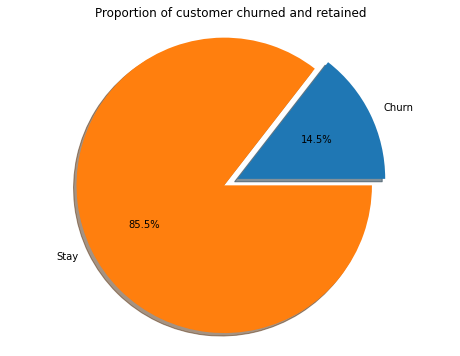

In [5]:
#default churn rate
labels = 'Churn', "Stay"
sizes = [df.Churn[df['Churn'] == 1].count(), df.Churn[df['Churn'] == 0].count()]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

plt.title("Proportion of customer churned and retained")

plt.show()

<a id="3"></a>
# 3. Model fitting with original data

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [7]:
#data preperation
label = df["Churn"]
df_train1 = df.iloc[:, 1:].copy() #wybór cech, wszystko poza zmienną Churn (bo churn to etykieta)
feature_names = list(df_train1.columns.values)

#I seperate the data into train, valiation and test. We will reserve the test set till the end to test the performance of the best model.

#set, testset
X_trainval, X_test, y_trainval, y_test = train_test_split(df_train1, label, test_size = 0.2, random_state=1)
#train, validation set split
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state=1)

### Baseline Model

In [8]:
#dummy model
dummy1 = DummyClassifier(random_state=1).fit(X_train, y_train)
pred_dummy1 = dummy1.predict(X_val)
print("randomly guessing score: {:.2f}".format(dummy1.score(X_val,y_val)))
dummy2 = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
pred_dummy2 = dummy2.predict(X_val)
print("guess all customers will stay score: {:.2f}".format(dummy2.score(X_val,y_val)))

randomly guessing score: 0.85
guess all customers will stay score: 0.85


### Different Tree models

In [9]:
#tree model
tree = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
print("Decision Tree validation score: {:.2f}".format(tree.score(X_val, y_val)))
tree_crossval = cross_val_score(tree, X_trainval, y_trainval)
print("Decision Tree cross-validation score: {:.2f}".format(tree_crossval.mean()))

#tree model with simple tune
tree_tune = DecisionTreeClassifier(random_state=1, max_depth = 6).fit(X_train, y_train)
#I picked 6 by just trying out different numbers. We can also use GridSearchCV to select the best parameters but I am a bit lazy to do so. 
print("Decision Tree validation score after tune: {:.2f}".format(tree_tune.score(X_val, y_val)))
pred_tree = tree.predict(X_val)
tree_crossval_tune = cross_val_score(tree_tune, X_trainval, y_trainval)
print("Decision Tree cross-validation score (tune): {:.2f}".format(tree_crossval_tune.mean()))

Decision Tree validation score: 0.90
Decision Tree cross-validation score: 0.89
Decision Tree validation score after tune: 0.92
Decision Tree cross-validation score (tune): 0.92


In [10]:
print("With original dataset")
#tree model with simple tune
tree_tune = DecisionTreeClassifier(random_state=1, max_depth = 6).fit(X_train, y_train)
#I picked 6 by just trying out different numbers. We can also use GridSearchCV to select the best parameters but I am a bit lazy to do so. 
print("Decision Tree validation score after tune: {:.2f}".format(tree_tune.score(X_val, y_val)))
pred_tree = tree.predict(X_val)
tree_crossval_tune = cross_val_score(tree_tune, X_trainval, y_trainval)
print("Decision Tree cross-validation score (tune): {:.2f}".format(tree_crossval_tune.mean()))

#random forest model
forest = RandomForestClassifier(random_state=1, max_depth=8).fit(X_train, y_train)
pred_forest = forest.predict(X_val)
print("\nRandom Forest validation score: {:.2f}".format(forest.score(X_val, y_val)))
forest_crossval = cross_val_score(forest, X_trainval, y_trainval)
print("Random Forest cross-validation score: {:.2f}".format(forest_crossval.mean()))

#Gradient Boosting model
gradient = GradientBoostingClassifier(random_state=1).fit(X_train, y_train)
pred_gradient = gradient.predict(X_val)
#print("Gradient Boosting train score: {:.2f}".format(gradient.score(X_train, y_train)))
print("\nGradient Boosting validation score: {:.2f}".format(gradient.score(X_val, y_val)))
gradient_crossval = cross_val_score(gradient, X_trainval, y_trainval)
print("Grandient Boosting cross-validation score: {:.2f}".format(gradient_crossval.mean()))

#XG bossting model
xg = XGBClassifier().fit(X_train, y_train)
pred_xg = xg.predict(X_val)
#print("XGBoost train score: {:.2f}".format(xg.score(X_train, y_train)))
print("\nXGBoost validation score: {:.2f}".format(xg.score(X_val, y_val)))
xg_crossval = cross_val_score(xg, X_trainval, y_trainval)
print("XGBoost cross-validation score: {:.2f}".format(xg_crossval.mean()))

With original dataset
Decision Tree validation score after tune: 0.92
Decision Tree cross-validation score (tune): 0.92

Random Forest validation score: 0.93
Random Forest cross-validation score: 0.94

Gradient Boosting validation score: 0.93
Grandient Boosting cross-validation score: 0.93

XGBoost validation score: 0.93
XGBoost cross-validation score: 0.93


<a id="3.1"></a>
# 3.1 Basic model Evaluation

In [11]:
print("With original dataset")
#confusion matrix for dummy
confusion_dummy = confusion_matrix(y_val, pred_dummy2)
print("confusion matrix for dummy model:\n{}".format(confusion_dummy))

#confusion matrix for trees 
confusion_tree=confusion_matrix(y_val, pred_tree)
print("confusion matrix for decision tree:\n{}".format(confusion_tree))
#confusion matrix for random forest
confusion_forest=confusion_matrix(y_val, pred_forest)
print("confusion matrix for random forest:\n{}".format(confusion_forest))
#confusion matrix for gradient boosting
confusion_gradient=confusion_matrix(y_val, pred_gradient)
print("confusion matrix for gradient boost:\n{}".format(confusion_gradient))
#confusion matrix for xgboost
confusion_xg=confusion_matrix(y_val, pred_xg)
print("confusion matrix for xg boosting:\n{}".format(confusion_xg))

With original dataset
confusion matrix for dummy model:
[[452   0]
 [ 82   0]]
confusion matrix for decision tree:
[[428  24]
 [ 32  50]]
confusion matrix for random forest:
[[445   7]
 [ 30  52]]
confusion matrix for gradient boost:
[[444   8]
 [ 28  54]]
confusion matrix for xg boosting:
[[444   8]
 [ 27  55]]


Based on the confusion matrix, the our RF model makes more False Negative mistakes, which means customers will churn but the model says it will stay. It is because we have so many "Stay" in the sample that the model is focusing on getting the "Stay" class right, not the "Churn" class. We will need to rebalance the dataset. 

In [12]:
#classification_report
#dummy
print("dummy classificatoin report\n")
print(classification_report(y_val, pred_dummy2, target_names = ["Stay", "Churn"]))
print("\nrandom forest classification report\n")
print(classification_report(y_val, pred_forest, target_names = ["Stay", "Churn"]))

dummy classificatoin report

              precision    recall  f1-score   support

        Stay       0.85      1.00      0.92       452
       Churn       0.00      0.00      0.00        82

    accuracy                           0.85       534
   macro avg       0.42      0.50      0.46       534
weighted avg       0.72      0.85      0.78       534


random forest classification report

              precision    recall  f1-score   support

        Stay       0.94      0.98      0.96       452
       Churn       0.88      0.63      0.74        82

    accuracy                           0.93       534
   macro avg       0.91      0.81      0.85       534
weighted avg       0.93      0.93      0.93       534



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the classification report aboved, the difference between the model's ability to predict "Stay" vs. to predict "Churn is even more obvious. Here are some reminders what "precision" and "recall" are:
* Precision: True Positive / (True Positive + False Positive). Let's translate to Englis and let's use the example of "Churn", which is 0.88. It means: The times the model rightly predicted customers will churn / (rightly predict churn + predict churn but the client stay) is 88% 
* Recall: True Positive / (True Positive + False Negative). Let's translate to Englis and let's use the example of "Churn", which is 0.63. It means: The times the model rightly predicted customers will churn / (rightly predict churn + predict stay but the client churn) is 63% 

<a id="4"></a>
# 4. Models With Resamplings

<a id="4.1"></a>
### 4.1 Downsample

In [13]:
from sklearn.utils import resample

In [14]:
df.Churn.value_counts()

0    2850
1     483
Name: Churn, dtype: int64

In [15]:
# Separate majority and minority classes
df_maj = df[df.Churn==0]
df_min = df[df.Churn==1]

print("The minority sample size is: {}".format(len(df_min))) #483

# Downsample majority class
df_maj_ds = resample(df_maj, replace=False,    # sample without replacement
                             n_samples=483,     # to match minority class
                             random_state=1) # reproducible results
# Combine minority class with downsampled majority class
df_ds = pd.concat([df_maj_ds, df_min])
 
# Display new class counts
df_ds.Churn.value_counts()


The minority sample size is: 483


0    483
1    483
Name: Churn, dtype: int64

In [16]:
#dat preperation
label2 = df_ds["Churn"]
df_ds_train = df_ds.iloc[:, 1:].copy()
feature_names2 = list(df_ds_train.columns.values)
#set, testset split
Xds_train, Xds_val, yds_train, yds_val = train_test_split(df_ds_train, label2, test_size = 0.2, random_state=1)

In [17]:
#tree after downsample
tree_ds = DecisionTreeClassifier(random_state=1, max_depth = 4).fit(Xds_train, yds_train)
print("Tree validation score: {:.2f}".format(tree_ds.score(X_val, y_val)))
tree_ds_crossval = cross_val_score(tree_ds, X_val, y_val)
print("Tree cross-validation score after ds: {:.2f}".format(tree_ds_crossval.mean()))

#random forest model after downsampled
forest_ds = RandomForestClassifier(random_state=1).fit(Xds_train, yds_train)
print("\nRandom Forest validation score: {:.2f}".format(forest_ds.score(X_val, y_val)))
forest_ds_crossval = cross_val_score(forest_ds, X_val, y_val)
print("Random Forest cross-validation score after ds: {:.2f}".format(forest_ds_crossval.mean()))

gradient_ds = GradientBoostingClassifier(random_state=1).fit(Xds_train, yds_train)
print("\nGradient Boosting validation score: {:.2f}".format(gradient_ds.score(X_val, y_val)))
gradient_ds_crossval = cross_val_score(gradient_ds, X_val, y_val)
print("Gradient Boosting cross-validation score after ds: {:.2f}".format(gradient_ds_crossval.mean()))

xg_ds = XGBClassifier(random_state=1).fit(Xds_train, yds_train)
print("\nXG Boosting validation score: {:.2f}".format(xg_ds.score(X_val, y_val)))
xg_ds_crossval = cross_val_score(xg_ds, X_val, y_val)
print("XG Boosting cross-validation score after ds: {:.2f}".format(xg_ds_crossval.mean()))

Tree validation score: 0.84
Tree cross-validation score after ds: 0.90

Random Forest validation score: 0.93
Random Forest cross-validation score after ds: 0.92

Gradient Boosting validation score: 0.91
Gradient Boosting cross-validation score after ds: 0.91

XG Boosting validation score: 0.91
XG Boosting cross-validation score after ds: 0.92


In [18]:
#confusion matrix for random forest downsampled
pred_tree_ds = tree_ds.predict(X_val)
confusion_tree_ds=confusion_matrix(y_val, pred_tree_ds)
print("\nconfusion matrix for tree after downsampling:\n{}".format(confusion_tree_ds))

pred_forest_ds = forest_ds.predict(X_val)
confusion_forest_ds=confusion_matrix(y_val, pred_forest_ds)
print("\nconfusion matrix for random forest after downsampling:\n{}".format(confusion_forest_ds))

pred_gradient_ds = gradient_ds.predict(X_val)
confusion_gradient_ds=confusion_matrix(y_val, pred_gradient_ds)
print("\nconfusion matrix for gradient boosting after downsampling:\n{}".format(confusion_gradient_ds))

pred_xg_ds = xg_ds.predict(X_val)
confusion_xg_ds=confusion_matrix(y_val, pred_xg_ds)
print("\nconfusion matrix for xg boosting after downsampling:\n{}".format(confusion_xg_ds))


confusion matrix for tree after downsampling:
[[381  71]
 [ 12  70]]

confusion matrix for random forest after downsampling:
[[414  38]
 [  2  80]]

confusion matrix for gradient boosting after downsampling:
[[412  40]
 [  6  76]]

confusion matrix for xg boosting after downsampling:
[[411  41]
 [  6  76]]


In [19]:
#classification_report
#dummy
print("xgb classificatoin report\n")
print(classification_report(y_val, pred_xg_ds, target_names = ["Stay", "Churn"]))
print("\nrandom forest classification report\n")
print(classification_report(y_val, pred_forest_ds, target_names = ["Stay", "Churn"]))

xgb classificatoin report

              precision    recall  f1-score   support

        Stay       0.99      0.91      0.95       452
       Churn       0.65      0.93      0.76        82

    accuracy                           0.91       534
   macro avg       0.82      0.92      0.85       534
weighted avg       0.93      0.91      0.92       534


random forest classification report

              precision    recall  f1-score   support

        Stay       1.00      0.92      0.95       452
       Churn       0.68      0.98      0.80        82

    accuracy                           0.93       534
   macro avg       0.84      0.95      0.88       534
weighted avg       0.95      0.93      0.93       534



False positive performance all improved but we also sacrificed for predicting class "1" due to the loss of information

<a id="4.3"></a>
### 4.3 SMOTE


In [20]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [21]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=1)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [22]:
#tree after smote
tree_sm = DecisionTreeClassifier(random_state=1, max_depth = 5).fit(Xsm_train, ysm_train)
print("Tree validation score after smote: {:.2f}".format(tree_sm.score(X_val, y_val)))
tree_sm_crossval = cross_val_score(tree_sm, X_val, y_val)
print("Tree cross-validation score after smote: {:.2f}".format(tree_sm_crossval.mean()))

#random forest model after downsampled
forest_sm = RandomForestClassifier(random_state=1).fit(Xsm_train, ysm_train)
print("\nRandom Forest validation score after smote: {:.2f}".format(forest_sm.score(X_val, y_val)))
forest_sm_crossval = cross_val_score(forest_sm, X_val, y_val)
print("Random Forest cross-validation score after smote: {:.2f}".format(forest_sm_crossval.mean()))
#gradient boosting
gradient_sm = GradientBoostingClassifier(random_state=1).fit(Xsm_train, ysm_train)
print("\nGradient Boosting validation score after smote: {:.2f}".format(gradient_sm.score(X_val, y_val)))
gradient_sm_crossval = cross_val_score(gradient_sm, X_val, y_val)
print("Gradient Boosting cross-validation score after smote: {:.2f}".format(gradient_sm_crossval.mean()))
#xgboost
xg_sm = XGBClassifier(random_state=1).fit(Xsm_train, ysm_train)
print("\nXG Boosting validation score after smote: {:.2f}".format(xg_sm.score(X_val, y_val)))
xg_sm_crossval = cross_val_score(xg_sm, X_val, y_val)
print("XG Boosting cross-validation score after smote: {:.2f}".format(xg_sm_crossval.mean()))

Tree validation score after smote: 0.93
Tree cross-validation score after smote: 0.89

Random Forest validation score after smote: 0.92
Random Forest cross-validation score after smote: 0.92

Gradient Boosting validation score after smote: 0.91
Gradient Boosting cross-validation score after smote: 0.91

XG Boosting validation score after smote: 0.92
XG Boosting cross-validation score after smote: 0.92


In [23]:
print("SMOTE")
pred_tree_sm = tree_sm.predict(X_val)
confusion_tree_sm=confusion_matrix(y_val, pred_tree_sm)
print("\nconfusion matrix for tree:\n{}".format(confusion_tree_sm))

pred_forest_sm = forest_sm.predict(X_val)
confusion_forest_sm=confusion_matrix(y_val, pred_forest_sm)
print("\nconfusion matrix for forest:\n{}".format(confusion_forest_sm))

pred_gradient_sm = gradient_sm.predict(X_val)
confusion_gradient_sm=confusion_matrix(y_val, pred_gradient_sm)
print("\nconfusion matrix for gradient:\n{}".format(confusion_gradient_sm))

pred_xg_sm = xg_sm.predict(X_val)
confusion_xg_sm=confusion_matrix(y_val, pred_xg_sm)
print("\nconfusion matrix for xg:\n{}".format(confusion_xg_sm))

SMOTE

confusion matrix for tree:
[[424  28]
 [ 12  70]]

confusion matrix for forest:
[[425  27]
 [ 17  65]]

confusion matrix for gradient:
[[419  33]
 [ 14  68]]

confusion matrix for xg:
[[420  32]
 [ 13  69]]


Performance for gradient and xg are very consistent. It's due to how their algorithms were designed. For the other tree methods, you can see the False positive rate improved a lot compare to when we used upsample. 

<a id="5"></a>
# 5. precision vs. recall curve

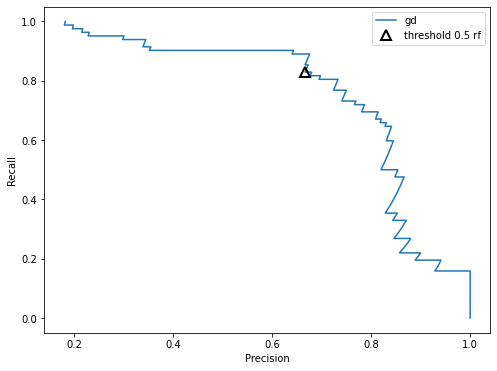

In [24]:
fig= plt.subplots(figsize=(8, 6))
precision_gd, recall_gd, thresholds_gd = precision_recall_curve(y_val, gradient_sm.predict_proba(X_val)[:, 1])
plt.plot(precision_gd, recall_gd, label="gd")

close_default_gd = np.argmin(np.abs(thresholds_gd - 0.5))
plt.plot(precision_gd[close_default_gd], recall_gd[close_default_gd], '^', c='k', markersize=10, label='threshold 0.5 rf', fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

Looks like we can maintain the same recall rate and improve the overall accuracy with an adjustment of the rate of threshold.

In [25]:
threshold = 0.38 #after different trails, this is the best

predicted_proba = gradient_sm.predict_proba(X_val)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

#compare the accuracy scores
accuracy_adj = accuracy_score(y_val, predicted)
print("accurcy rate with 0.38 threshold {}".format(str(round(accuracy_adj,4,)*100))+"%")

accuracy = accuracy_score(y_val, pred_gradient_sm)
print("accurcy rate with 0.5 threshold {}".format(str(round(accuracy,4,)*100))+"%")

#confusion matrix compare
confusion_gd=confusion_matrix(y_val, predicted)
print("confusion matrix with new threshold:\n{}".format(confusion_gd))

pred_gradient_sm = gradient_sm.predict(X_val)
confusion_gd_sm=confusion_matrix(y_val, pred_gradient_sm)
print("\nconfusion matrix original:\n{}".format(confusion_gd_sm))

#classification_report
print("\nrandom forest classification report with adjuested threshold\n")
print(classification_report(y_val, predicted, target_names = ["Stay", "Churn"]))

accurcy rate with 0.38 threshold 91.75999999999999%
accurcy rate with 0.5 threshold 91.2%
confusion matrix with new threshold:
[[417  35]
 [  9  73]]

confusion matrix original:
[[419  33]
 [ 14  68]]

random forest classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       0.98      0.92      0.95       452
       Churn       0.68      0.89      0.77        82

    accuracy                           0.92       534
   macro avg       0.83      0.91      0.86       534
weighted avg       0.93      0.92      0.92       534



In [ ]:
predicted_proba[:, 1]

array([0.12067217, 0.10773433, 0.17083737, 0.11299862, 0.8913275 ,
       0.07364557, 0.06342428, 0.86622488, 0.05349002, 0.7510961 ,
       0.09297183, 0.87640236, 0.13303853, 0.19279507, 0.05400125,
       0.08894297, 0.1740939 , 0.20613444, 0.10756529, 0.11149926,
       0.96450975, 0.96854885, 0.13864646, 0.11706721, 0.09637349,
       0.12145182, 0.0415177 , 0.73797765, 0.09290503, 0.21982072,
       0.21144369, 0.13445998, 0.1035753 , 0.76468103, 0.14633966,
       0.13011333, 0.04036322, 0.06327453, 0.17719716, 0.0306316 ,
       0.1150425 , 0.07628902, 0.91023643, 0.1522265 , 0.56529198,
       0.08811679, 0.97912077, 0.11594837, 0.03445386, 0.15753145,
       0.12329935, 0.19218185, 0.03538123, 0.13326228, 0.15121033,
       0.98098482, 0.11817944, 0.05936582, 0.14406182, 0.51094641,
       0.95817127, 0.13814614, 0.05435373, 0.1213978 , 0.10842882,
       0.14531541, 0.12426799, 0.69979549, 0.716264  , 0.09328614,
       0.1846133 , 0.13004794, 0.80200181, 0.94746622, 0.03753

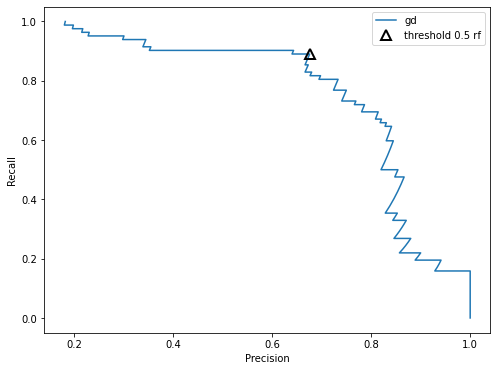

In [26]:
fig= plt.subplots(figsize=(8, 6))
precision_gd, recall_gd, thresholds_gd = precision_recall_curve(y_val, gradient_sm.predict_proba(X_val)[:, 1])
plt.plot(precision_gd, recall_gd, label="gd")

close_default_gd = np.argmin(np.abs(thresholds_gd - 0.4))
plt.plot(precision_gd[close_default_gd], recall_gd[close_default_gd], '^', c='k', markersize=10, label='threshold 0.5 rf', fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

<a id="6"></a>
# 6. final test

In [27]:
print("Random Forest final test score: {:.2f}".format(forest_ds.score(X_test, y_test)))
foresttest_crossval = cross_val_score(forest_ds, df_train1, label)
print("Random Forest final cross-validation test score: {:.2f}".format(foresttest_crossval.mean()))

test_forest = forest_ds.predict(X_test)
confusion_foresttest=confusion_matrix(y_test, test_forest)
print("\nconfusion matrix:\n{}".format(confusion_foresttest))

foresttest_proba = forest_ds.predict_proba(X_test)

foresttest = (foresttest_proba [:,1] >= 0.56).astype('int')

forestaccuracy_test = accuracy_score(y_test, foresttest)
#test_crossval2 = cross_val_score(test, df_train1, label)
print("\naccurcy rate with test data with 0.56 threshold is {}".format(str(round(forestaccuracy_test,4,)*100))+"%")
#print("cross-validation rate with test data is {}".format(str(round(test_crossval2,4,)*100))+"%")
      
print("\nrandom forest classification report with adjuested threshold\n")
print(classification_report(y_test, foresttest, target_names = ["Stay", "Churn"]))

Random Forest final test score: 0.90
Random Forest final cross-validation test score: 0.94

confusion matrix:
[[507  62]
 [  2  96]]

accurcy rate with test data with 0.56 threshold is 91.75%

random forest classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       1.00      0.91      0.95       569
       Churn       0.64      0.98      0.78        98

    accuracy                           0.92       667
   macro avg       0.82      0.94      0.86       667
weighted avg       0.94      0.92      0.92       667



In [28]:
print("Random Forest final test score: {:.2f}".format(forest_sm.score(X_test, y_test)))
forestsmtest_crossval = cross_val_score(forest_sm, df_train1, label)
print("Random Forest final cross-validation test score for smote: {:.2f}".format(forestsmtest_crossval.mean()))

test_forestsm = forest_sm.predict(X_test)
confusion_forestsmtest=confusion_matrix(y_test, test_forestsm)
print("\nconfusion matrix:\n{}".format(confusion_forestsmtest))

forestsmtest_proba = forest_sm.predict_proba(X_test)

forestsmtest = (forestsmtest_proba [:,1] >= 0.56).astype('int')

forestsmaccuracy_test = accuracy_score(y_test, forestsmtest)
#test_crossval2 = cross_val_score(test, df_train1, label)
print("\naccurcy rate with test data with 0.56 threshold is {}".format(str(round(forestsmaccuracy_test,4,)*100))+"%")
#print("cross-validation rate with test data is {}".format(str(round(test_crossval2,4,)*100))+"%")
      
print("\nrandom forest classification report with adjuested threshold\n")
print(classification_report(y_test, forestsmtest, target_names = ["Stay", "Churn"]))

Random Forest final test score: 0.91
Random Forest final cross-validation test score for smote: 0.94

confusion matrix:
[[531  38]
 [ 25  73]]

accurcy rate with test data with 0.56 threshold is 90.85%

random forest classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       0.96      0.94      0.95       569
       Churn       0.67      0.74      0.71        98

    accuracy                           0.91       667
   macro avg       0.81      0.84      0.83       667
weighted avg       0.91      0.91      0.91       667



In [29]:
print("Gradient Boosting final test score: {:.2f}".format(gradient_sm.score(X_test, y_test)))
gdtest_crossval = cross_val_score(gradient_sm, df_train1, label)
print("Gradient Boosting final cross-validation test score: {:.2f}".format(gdtest_crossval.mean()))

test_gd = gradient_sm.predict(X_test)
gdconfusion_test=confusion_matrix(y_test, test_gd)
print("\nconfusion matrix:\n{}".format(gdconfusion_test))

test_gd_original = gradient.predict(X_test)
gdoconfusion_test=confusion_matrix(y_test, test_gd_original)
print("\nconfusion matrix without sm:\n{}".format(gdoconfusion_test))

gdtest_proba = gradient_sm.predict_proba(X_test)

gdtest = (gdtest_proba [:,1] >= 0.38).astype('int')
#macierz pomyłek ze SMOTE
gdconfusion_test2=confusion_matrix(y_test, gdtest)
print("\nconfusion matrix with 0.38 threshold:\n{}".format(gdconfusion_test2))

gdaccuracy_test = accuracy_score(y_test, gdtest)
print("\naccurcy rate with test data with 0.38 threshold is {}".format(str(round(gdaccuracy_test,4,)*100))+"%")

      
print("\ngradient boost classification report with adjuested threshold\n")
print(classification_report(y_test, gdtest, target_names = ["Stay", "Churn"]))

test_gdo = gradient.predict(X_test)
print("\ngradient boost classification report original\n")
print(classification_report(y_test, test_gdo, target_names = ["Stay", "Churn"]))

Gradient Boosting final test score: 0.89
Gradient Boosting final cross-validation test score: 0.94

confusion matrix:
[[520  49]
 [ 24  74]]

confusion matrix without sm:
[[558  11]
 [ 31  67]]

confusion matrix with 0.38 threshold:
[[507  62]
 [ 20  78]]

accurcy rate with test data with 0.38 threshold is 87.71%

gradient boost classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       0.96      0.89      0.93       569
       Churn       0.56      0.80      0.66        98

    accuracy                           0.88       667
   macro avg       0.76      0.84      0.79       667
weighted avg       0.90      0.88      0.89       667


gradient boost classification report original

              precision    recall  f1-score   support

        Stay       0.95      0.98      0.96       569
       Churn       0.86      0.68      0.76        98

    accuracy                           0.94       667
   macro avg       0.90     

Case study cz.1

*   Wczytaj dane telecom_churn, przygotuj je tzn 


*   usun braki w danych lub zamień jakąs wartością może być srednia
*   usun lub zamień na wartość średnia wartości odstające


*  Jezeli potrzebujesz to użyj StandarScaler i Label Enocder
*   Użyj pakiet resample po to aby przeprowadzić Oversampling



*   Wykonaj uczenie dwoma algorytmami (jeden z rodziny: drzewo decyzyjne, svm, logistic regression, drugi: random forest, ada boost, xgboost
*   Wybierz najlepszy i zapisz jako odp jego precision i recall na zbiorze testowym










Case study cz.2

*   Użyj metody SMOTE (spróbuj wykonać kilka testów z różną liczbą sąsiadów)


*   Przeprowadź grid search dla algorytmow które zaimplementujesz w poprzednim punkcie (zwróć uwagę na czas)


*   Wykonaj uczenie na 3 algorytmach (2 mogą być te same co w pkt. 1, a 3 jeden z poniższej grupy gradient_boosting, lightgbm

Jako wynik zapisz f1_score na zbiorze testowym dla najlepszego algorytmu